<center><img src = "https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/BRATS_banner_noCaption.png" width = "800"/></center>
<center><str><a target="_blank" href="https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/BRATS_banner_noCaption.png">Image Source</a></str></center>

![image](Images/segmentation.gif)

# Introduction

In the last few years, the area of computer vision has undergone substantial development. This branch of technology is dedicated to the comprehensive set of processes involved in obtaining, processing, analyzing, and comprehending digital images to extract meaningful information.

One key technique among these processes is known as image segmentation. This specific method plays a crucial role in dividing an image into parts or segments to simplify or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is fundamental in identifying objects and boundaries (lines, curves, etc.) in images, making it a critical step in many computer vision tasks.

Computer vision, with a focus on image segmentation, plays a pivotal role in medical imaging by enabling precise segmentation of brain tumors. This technology facilitates accurate tumor identification and boundary delineation within MRI scans, which is essential for diagnosis, treatment planning, and monitoring the progression of brain tumors. By automating and enhancing the analysis of medical images, image segmentation significantly contributes to improved patient outcomes in the field of neuro-oncology.

This notebook focuses on the preprocessing of the BraTS 2020 dataset for Brain Tumor Segmentation. The BraTS 2020 dataset consists of multimodal MRI scans along with manual segmentations of brain tumors, essential for developing machine learning models for accurate and automated tumor segmentation.

The preprocessing steps covered include:
1. **Loading the dataset and necessary libraries** to handle medical images.
2. **Splitting the dataset** into training, testing and validation sets to evaluate model performance.
3. **Visualizing MRI scans** and their corresponding ground truth segmentations to understand the datasest.
4. **Preparing the data** for modeling, including normalization, resizing and augmentation.

This preparation is crucial for any subsequent model training and evaluation, aiming to improve the accuracy and efficency of brain tumor segmentation.

# Dataset Information

The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:
1. **Native (T1)**
2. **Post-contrast T1-weighted (T1ce - contrast enhanced)**
3. **T2-weighted (T2)**
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)**

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
  1. **Label 0**: Unalbeled volume
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing (No pixels in all the volumes contain label 3)
  5. **Label 4**: GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be reassigning label 3 with label 4 so that there is continuity between the labels.

We will combine FLAIR, T1ce and T2 into a single volume as it will give us rich information. And we will ignore T1 as the features we see in the mask are clearly visible in T1ce, T2 and FLAIR.

# Loading the Necessary Libraries

In [89]:
import numpy as np
import nibabel as nib
import glob
import shutil
import os
from tensorflow.keras.utils import to_categorical
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tifffile import imsave
from skimage.util import montage
from skimage.transform import rotate
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import gif_your_nifti.core as gif2nif
import nilearn as nl
import nilearn.plotting as nlplt

# Load Sample Images and Visualize

<div class="alert alert-block alert-warning">
Before moving forward, we must correct a small error in the dataset. The segmentation file in "BraTS20_Training_355" folder has an incorrect name. Now we will rename it to keep the same name as others.
</div>

In [57]:
TRAIN_DATASET_PATH = "D:/Brain Tumor Segmentation FYP/Dataset/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [58]:
old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File renamed!")
except FileNotFoundError:
    print("Unable to rename the file or it has already been renamed!")

Unable to rename the file or it has already been renamed!


## Data Exploration

In [59]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [60]:
print(test_image_flair.max())

1854.603271484375


As we can see the maximum pixel value of the image is "1854.6" which gives us a good idea to rescale these values. Rescaling pixel values is essential because it standardizes the intensity values across multimodal MRI scans (T1, T1ce, T2, FLAIR) to a uniform scale. This uniformity is crucial for consistent model training and analysis, as it ensures that variations in pixel intensity due to different imaging modalities and equipment do not bias the segmentation model. It facilitates the model's ability to learn meaningful features from the data for accurate tumor segmentation, regardless of the inherent differences in the raw MRI scans.

In [61]:
scaler = MinMaxScaler()

In [62]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [63]:
print(test_image_flair.max())

1.0


Now we can see that the pixel values are scaled between 0 - 1.

In [64]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

In [65]:
print("Before: ", test_mask.dtype)

Before:  float64


In [66]:
# converting to integer
test_mask = test_mask.astype(np.uint8)
print("After: ", test_mask.dtype)

After:  uint8


In [67]:
#0, 1, 2, 4 (Need to re-encode to 0, 1, 2, 3)
print(np.unique(test_mask))

[0 1 2 4]


In [68]:
# re-assigning mask values 4 to 3
test_mask[test_mask==4] = 3
print(np.unique(test_mask))

[0 1 2 3]


Slice: 95th


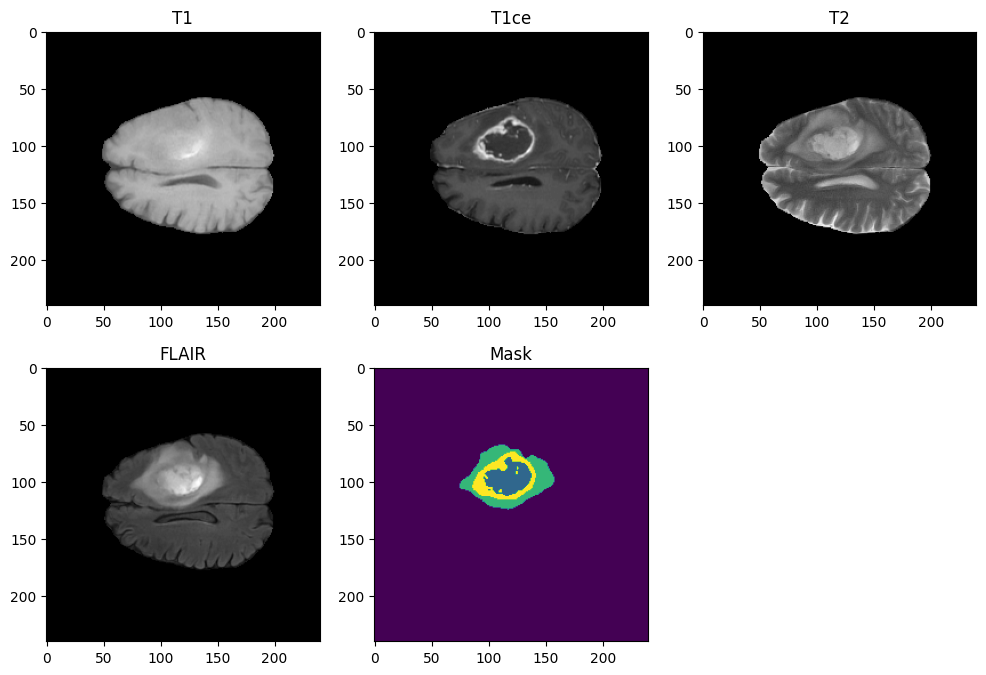

In [69]:
slice_w = 25

print("Slice: " + str(test_image_t1ce.shape[0]//2-slice_w) + "th")

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
plt.title('Mask')
plt.show()

As we can see, the four modalities bring out different aspects for the same image.

To be more specific, here is a description of their interest:

- **Native (T1)**: Used to show the structure and composition of different types of tissue in the brain and to identify tumors, cysts, and other abnormalities.
- **Post-contrast T1-weighted (T1ce, also named T1Gd):** Similar to T1 images but with the injection of a contrast agent (Gadolinium) which will enhance the visibility of abnormalities.
- **T2-weighted (T2):** Used to show the fluid content of different types of tissue in the brain.
- **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery):** Used to suppress this fluid content. This can be useful for identifying lesions that are not clearly visible on T1 or T2 images, and also for identifying lesions in the white matter of the brain, which can be difficult to see on other types of scans.

For an expert, it can be useful to have these 4 modalities in order to analyze the tumor more precisely, and to confirm its presence or not.
But for our artificial approach, **using only two modalities instead of four** is interesting since it can reduce the computational and memory requirements of the segmentation task, making it faster and more efficient. That is why we will **exclude T1**, since we have its improved version T1ce. We will also **exclude the T2 modality** because the fluids it presents could degrade our predictions. These fluids are removed in the flair version, which highlights the affected regions much better, and will therefore be much more interesting for our training.

## Images Format

You may have noticed that these images are in `.nii` format. These scans are NIfTI files (*Neuroimaging Informatics Technology Initiative*). A NIfTI image is a digital representation of a 3D object, such as a brain in our case. To understand this more closely, let's display the shape of a modality scan and of a segmentation (they all have the same in this dataset): 

In [17]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_mask.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As we can see, modalities & segmentations do have 3 dimensions. Each dimension is composed of a series of two-dimensional images, known as **slices**, which all contain the same number of pixels, and are stacked together to create this 3D representation. That is why we have displayed 2D images just above (you may not have noticed but we have displayed the **95th slice** of a certain dimension).

These 3 dimensions correspond to the three spatial dimensions of the image : width, height, and depth. In medical imaging, they are named `axial/transverse, coronal, and sagittal planes`, corresponding to the three main orientations of the human body, and therefore the human brain.

Here is a quick presentation of these 3 planes: 
 
<center><img src = "https://i0.wp.com/www.rishacademy.com/wp-content/uploads/2021/06/anatomicalplanes.png?fit=540%2C430&ssl=1" width = "500"/></center>
<center><str><a target="_blank" href="https://i0.wp.com/www.rishacademy.com/wp-content/uploads/2021/06/anatomicalplanes.png?fit=540%2C430&ssl=1">Image Source</a></str></center>

- **Transverse/Axial Plane**: It divides the body into top and bottom sections and is often referred to as a "head-toe" plane.
- **Frontal/Coronal Plane**: It divides the body into front and back sections and is often referred to as a "side-side" plane.
- **Sagittal/Lateral Plane**: It divides the body into left and right sections and is often referred to as a "front-back" plane.

We can display each modality through its different planes. For example, we will display the 3 planes of the T1 image:

Slice: 95th


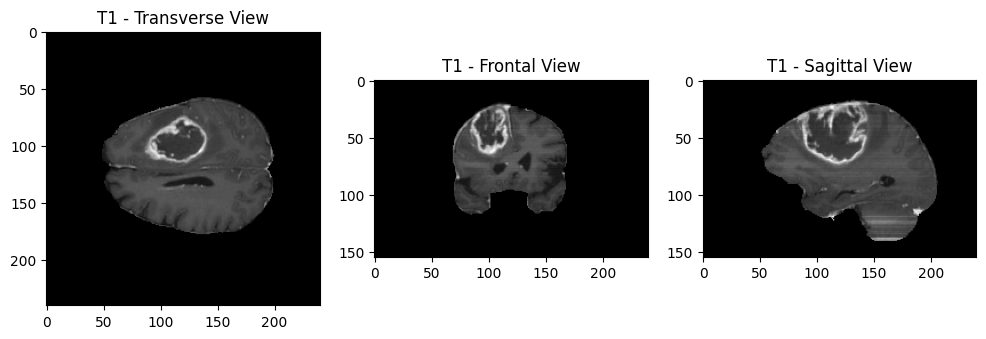

In [18]:
slice_w = 25

print("Slice: " + str(test_image_t1ce.shape[0]//2-slice_w) + "th")

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,test_image_t1ce.shape[0]//2-slice_w,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[test_image_t1ce.shape[0]//2-slice_w,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

Now that we know why we have three dimensions, let's try to understand why we chose to display a specific slice. 

To do this, we will display all the slices: 

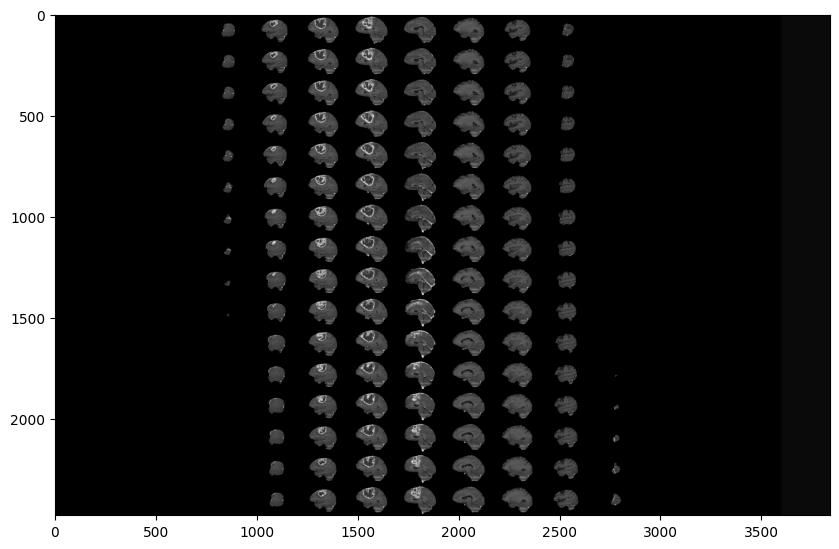

In [78]:
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
# montage allows us to concatenate multiple images of the same size horizontally and vertically
ax1.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

As we can see, the two dark areas are present on each side of our montage. However, these dark areas correspond to the first and last slices of a plane. This means that a large part of the slices does not contain much information. This is not surprising since the slices progressively represent the brain.

This analysis is the same on all other modalities, all planes and also on the images segmented by the experts. Indeed, they were not able to segment the slices that do not contain much information.

This is why we can exclude these slices in our analysis, in order to reduce the number of manipulated images. We can see that a `(70:134)` range will be much more interesting:

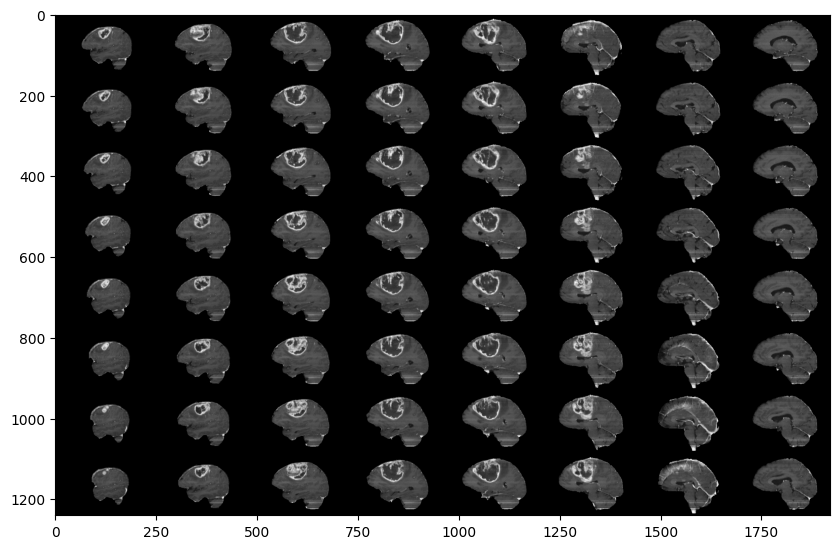

In [83]:
# Skip 70:134 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
ax1.imshow(rotate(montage(test_image_t1ce[70:134,:,:]), 90, resize=True), cmap ='gray');

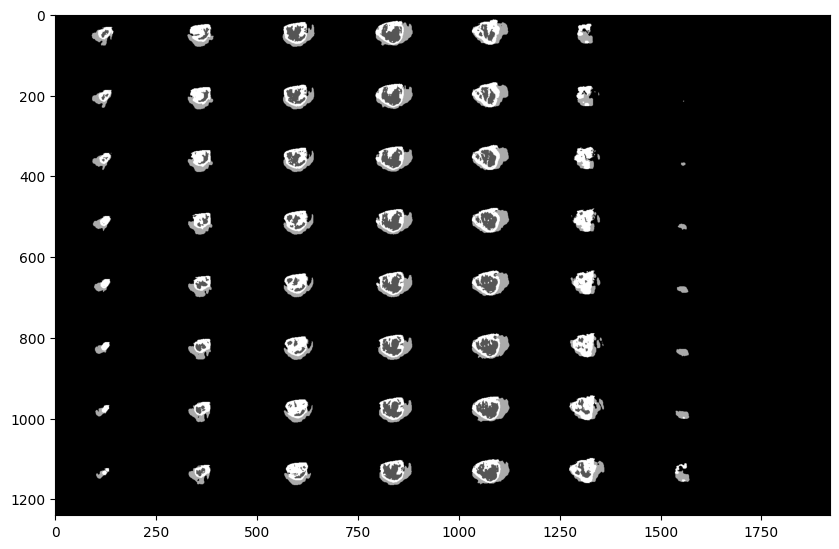

In [86]:
# Skip 70:134 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
ax1.imshow(rotate(montage(test_mask[70:134,:,:]), 90, resize=True), cmap ='gray');

Now, let's focus on the segmentations provided by the experts. What information do they give us? 

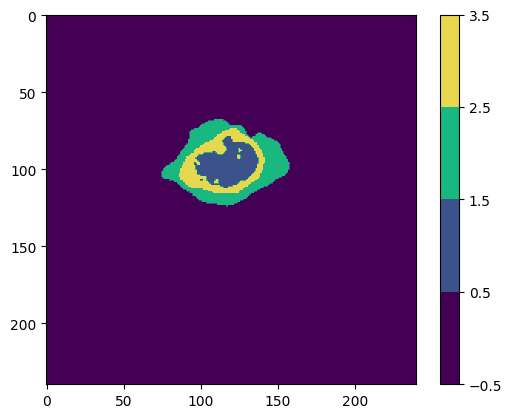

In [97]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_mask[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()